# Check OS

In [1]:
!lsb_release -a

No LSB modules are available.
Distributor ID:	Debian
Description:	Debian GNU/Linux 9.8 (stretch)
Release:	9.8
Codename:	stretch


In [2]:
!sudo apt install tree

Reading package lists... Done
Building dependency tree       
Reading state information... Done
tree is already the newest version (1.7.0-5).
0 upgraded, 0 newly installed, 0 to remove and 2 not upgraded.


# View Dataset Details

In [3]:
!tree --dirsfirst --filelimit 5 "./cell_images"

./cell_images
├── Parasitized [13780 entries exceeds filelimit, not opening dir]
└── Uninfected [13780 entries exceeds filelimit, not opening dir]

2 directories, 0 files


In [4]:
import os
import glob

base_dir = os.path.join('./cell_images')
infected_dir = os.path.join(base_dir,'Parasitized')
healthy_dir = os.path.join(base_dir,'Uninfected')

infected_files = glob.glob(infected_dir+'/*.png')
healthy_files = glob.glob(healthy_dir+'/*.png')
len(infected_files), len(healthy_files)

(13779, 13779)

In [5]:
import numpy as np
import pandas as pd

np.random.seed(42)

files_df = pd.DataFrame({
    'filename': infected_files + healthy_files,
    'label': ['malaria'] * len(infected_files) + ['healthy'] * len(healthy_files)
}).sample(frac=1, random_state=42).reset_index(drop=True)

files_df.head()

,filename,label
0,./cell_images/Parasitized/C59P20thinF_IMG_2015...,malaria
1,./cell_images/Parasitized/C180P141NThinF_IMG_2...,malaria
2,./cell_images/Uninfected/C154P115ThinF_IMG_201...,healthy
3,./cell_images/Uninfected/C69P30N_ThinF_IMG_201...,healthy
4,./cell_images/Uninfected/C182P143NThinF_IMG_20...,healthy


# Create Train, Validation and Test Datasets

In [6]:
from sklearn.model_selection import train_test_split
from collections import Counter

train_files, test_files, train_labels, test_labels = train_test_split(files_df['filename'].values,
                                                                      files_df['label'].values, 
                                                                      test_size=0.3, random_state=42)
train_files, val_files, train_labels, val_labels = train_test_split(train_files,
                                                                    train_labels, 
                                                                    test_size=0.1, random_state=42)

print(train_files.shape, val_files.shape, test_files.shape)
print('Train:', Counter(train_labels), '\nVal:', Counter(val_labels), '\nTest:', Counter(test_labels))

(17361,) (1929,) (8268,)
Train: Counter({'healthy': 8734, 'malaria': 8627}) 
Val: Counter({'healthy': 970, 'malaria': 959}) 
Test: Counter({'malaria': 4193, 'healthy': 4075})


## Get Image Dimension Summary Stats

In [7]:
import cv2
from concurrent import futures
import threading

def get_img_shape_parallel(idx, img, total_imgs):
    if idx % 5000 == 0 or idx == (total_imgs - 1):
        print('{}: working on img num: {}'.format(threading.current_thread().name,
                                                  idx))
    return cv2.imread(img).shape
  
ex = futures.ThreadPoolExecutor(max_workers=None)
data_inp = [(idx, img, len(train_files)) for idx, img in enumerate(train_files)]
print('Starting Img shape computation:')
train_img_dims_map = ex.map(get_img_shape_parallel, 
                            [record[0] for record in data_inp],
                            [record[1] for record in data_inp],
                            [record[2] for record in data_inp])
train_img_dims = list(train_img_dims_map)
print('Min Dimensions:', np.min(train_img_dims, axis=0)) 
print('Avg Dimensions:', np.mean(train_img_dims, axis=0))
print('Median Dimensions:', np.median(train_img_dims, axis=0))
print('Max Dimensions:', np.max(train_img_dims, axis=0))

Starting Img shape computation:
ThreadPoolExecutor-0_0: working on img num: 0
ThreadPoolExecutor-0_17: working on img num: 5000
ThreadPoolExecutor-0_15: working on img num: 10000
ThreadPoolExecutor-0_1: working on img num: 15000
ThreadPoolExecutor-0_7: working on img num: 17360
Min Dimensions: [46 46  3]
Avg Dimensions: [132.77311215 132.45757733   3.        ]
Median Dimensions: [130. 130.   3.]
Max Dimensions: [385 394   3]


## Load and Resize Images

In [8]:
IMG_DIMS = (125, 125)

def get_img_data_parallel(idx, img, total_imgs):
    if idx % 5000 == 0 or idx == (total_imgs - 1):
        print('{}: working on img num: {}'.format(threading.current_thread().name,
                                                  idx))
    img = cv2.imread(img)
    img = cv2.resize(img, dsize=IMG_DIMS, 
                     interpolation=cv2.INTER_CUBIC)
    img = np.array(img, dtype=np.float32)
    return img

ex = futures.ThreadPoolExecutor(max_workers=None)
train_data_inp = [(idx, img, len(train_files)) for idx, img in enumerate(train_files)]
val_data_inp = [(idx, img, len(val_files)) for idx, img in enumerate(val_files)]
test_data_inp = [(idx, img, len(test_files)) for idx, img in enumerate(test_files)]

print('Loading Train Images:')
train_data_map = ex.map(get_img_data_parallel, 
                        [record[0] for record in train_data_inp],
                        [record[1] for record in train_data_inp],
                        [record[2] for record in train_data_inp])
train_data = np.array(list(train_data_map))

print('\nLoading Validation Images:')
val_data_map = ex.map(get_img_data_parallel, 
                        [record[0] for record in val_data_inp],
                        [record[1] for record in val_data_inp],
                        [record[2] for record in val_data_inp])
val_data = np.array(list(val_data_map))

print('\nLoading Test Images:')
test_data_map = ex.map(get_img_data_parallel, 
                        [record[0] for record in test_data_inp],
                        [record[1] for record in test_data_inp],
                        [record[2] for record in test_data_inp])
test_data = np.array(list(test_data_map))

train_data.shape, val_data.shape, test_data.shape  

Loading Train Images:
ThreadPoolExecutor-1_0: working on img num: 0
ThreadPoolExecutor-1_12: working on img num: 5000
ThreadPoolExecutor-1_6: working on img num: 10000
ThreadPoolExecutor-1_10: working on img num: 15000
ThreadPoolExecutor-1_3: working on img num: 17360

Loading Validation Images:
ThreadPoolExecutor-1_13: working on img num: 0
ThreadPoolExecutor-1_18: working on img num: 1928

Loading Test Images:
ThreadPoolExecutor-1_5: working on img num: 0
ThreadPoolExecutor-1_19: working on img num: 5000
ThreadPoolExecutor-1_8: working on img num: 8267


((17361, 125, 125, 3), (1929, 125, 125, 3), (8268, 125, 125, 3))

# View Sample Cell Images

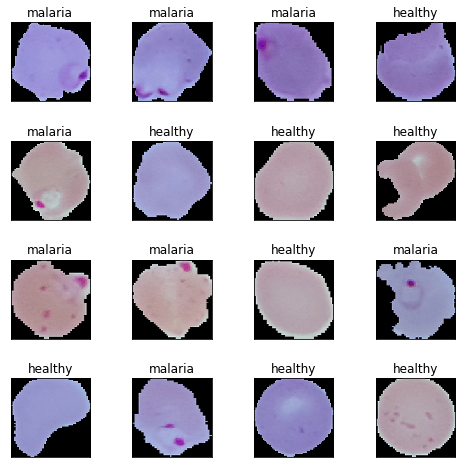

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(1 , figsize = (8 , 8))
n = 0 
for i in range(16):
    n += 1 
    r = np.random.randint(0 , train_data.shape[0] , 1)
    plt.subplot(4 , 4 , n)
    plt.subplots_adjust(hspace = 0.5 , wspace = 0.5)
    plt.imshow(train_data[r[0]]/255.)
    plt.title('{}'.format(train_labels[r[0]]))
    plt.xticks([]) , plt.yticks([])

# Setup config settings, Scale Images & Label encode classes

In [10]:
BATCH_SIZE = 64
NUM_CLASSES = 2
EPOCHS = 25
INPUT_SHAPE = (125, 125, 3)

train_imgs_scaled = train_data / 255.
val_imgs_scaled = val_data / 255.

# encode text category labels
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(train_labels)
train_labels_enc = le.transform(train_labels)
val_labels_enc = le.transform(val_labels)

print(train_labels[:6], train_labels_enc[:6])

['malaria' 'malaria' 'malaria' 'healthy' 'healthy' 'malaria'] [1 1 1 0 0 1]


In [11]:
import tensorflow as tf

# Load the TensorBoard notebook extension (optional)
%load_ext tensorboard.notebook

tf.random.set_seed(42)
tf.__version__

'2.0.0-alpha0'

# Model 1: CNN from Scratch

## Build Model Architecture

In [12]:
inp = tf.keras.layers.Input(shape=INPUT_SHAPE)

conv1 = tf.keras.layers.Conv2D(32, kernel_size=(3, 3), 
                               activation='relu', padding='same')(inp)
pool1 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv1)
conv2 = tf.keras.layers.Conv2D(64, kernel_size=(3, 3), 
                               activation='relu', padding='same')(pool1)
pool2 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv2)
conv3 = tf.keras.layers.Conv2D(128, kernel_size=(3, 3), 
                               activation='relu', padding='same')(pool2)
pool3 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv3)

flat = tf.keras.layers.Flatten()(pool3)

hidden1 = tf.keras.layers.Dense(512, activation='relu')(flat)
drop1 = tf.keras.layers.Dropout(rate=0.3)(hidden1)
hidden2 = tf.keras.layers.Dense(512, activation='relu')(drop1)
drop2 = tf.keras.layers.Dropout(rate=0.3)(hidden2)

out = tf.keras.layers.Dense(1, activation='sigmoid')(drop2)

model = tf.keras.Model(inputs=inp, outputs=out)
model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 125, 125, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 125, 125, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 62, 62, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 62, 62, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 31, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 31, 31, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 15, 15, 128)       0     

## Train Model

In [13]:
import datetime

logdir = os.path.join('/home/dipanzan_sarkar/projects/tensorboard_logs', 
                      datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=2, min_lr=0.000001)

#early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=5, 
#                                              mode='auto', baseline=None, restore_best_weights=False)
callbacks = [reduce_lr, tensorboard_callback]

history = model.fit(x=train_imgs_scaled, y=train_labels_enc, 
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS, 
                    validation_data=(val_imgs_scaled, val_labels_enc), 
                    callbacks=callbacks,
                    verbose=1)

Train on 17361 samples, validate on 1929 samples
Epoch 1/25
17361/17361 [==============================] - 32s 2ms/sample - loss: 0.4373 - accuracy: 0.7814 - val_loss: 0.1834 - val_accuracy: 0.9393
Epoch 2/25
17361/17361 [==============================] - 30s 2ms/sample - loss: 0.1725 - accuracy: 0.9434 - val_loss: 0.1567 - val_accuracy: 0.9513
Epoch 3/25
17361/17361 [==============================] - 30s 2ms/sample - loss: 0.1418 - accuracy: 0.9543 - val_loss: 0.1459 - val_accuracy: 0.9570
Epoch 4/25
17361/17361 [==============================] - 30s 2ms/sample - loss: 0.1235 - accuracy: 0.9585 - val_loss: 0.1464 - val_accuracy: 0.9611
Epoch 5/25
17361/17361 [==============================] - 30s 2ms/sample - loss: 0.1115 - accuracy: 0.9619 - val_loss: 0.1444 - val_accuracy: 0.9596
Epoch 6/25
17361/17361 [==============================] - 30s 2ms/sample - loss: 0.0989 - accuracy: 0.9672 - val_loss: 0.1767 - val_accuracy: 0.9570
Epoch 7/25
17361/17361 [==============================] -

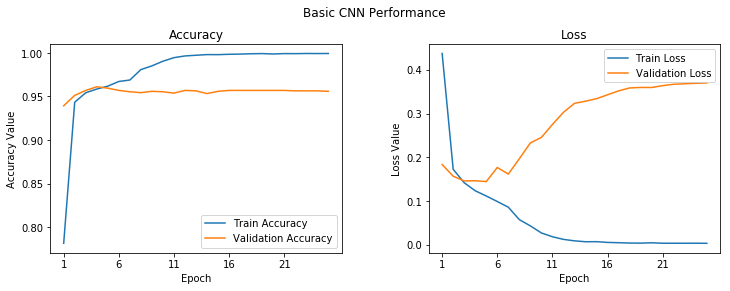

In [14]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Basic CNN Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

max_epoch = len(history.history['accuracy'])+1
epoch_list = list(range(1,max_epoch))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(1, max_epoch, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(1, max_epoch, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

## Save Model

In [15]:
model.save('basic_cnn.h5')

# Transfer Learning 
# Model 2: Frozen Pre-trained CNN 

## Build Model Architecture

In [16]:
vgg = tf.keras.applications.vgg19.VGG19(include_top=False, weights='imagenet', 
                                        input_shape=INPUT_SHAPE)
vgg.trainable = False
# Freeze the layers
for layer in vgg.layers:
    layer.trainable = False
    
base_vgg = vgg
base_out = base_vgg.output
pool_out = tf.keras.layers.Flatten()(base_out)
hidden1 = tf.keras.layers.Dense(512, activation='relu')(pool_out)
drop1 = tf.keras.layers.Dropout(rate=0.3)(hidden1)
hidden2 = tf.keras.layers.Dense(512, activation='relu')(drop1)
drop2 = tf.keras.layers.Dropout(rate=0.3)(hidden2)

out = tf.keras.layers.Dense(1, activation='sigmoid')(drop2)

model = tf.keras.Model(inputs=base_vgg.input, outputs=out)
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=1e-4),
                loss='binary_crossentropy',
                metrics=['accuracy'])
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 125, 125, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 125, 125, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 125, 125, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 62, 62, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 62, 62, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 62, 62, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 31, 31, 128)       0   

In [17]:
print("Total Layers:", len(model.layers))
print("Total trainable layers:", sum([1 for l in model.layers if l.trainable]))

Total Layers: 28
Total trainable layers: 6


## Train Model

In [18]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=2, min_lr=0.000001)

#early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=15, 
#                                              mode='auto', baseline=None, restore_best_weights=False)
callbacks = [reduce_lr, tensorboard_callback]

history = model.fit(x=train_imgs_scaled, y=train_labels_enc, 
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS, 
                    validation_data=(val_imgs_scaled, val_labels_enc), 
                    callbacks=callbacks,
                    verbose=1)

Train on 17361 samples, validate on 1929 samples
Epoch 1/25
17361/17361 [==============================] - 92s 5ms/sample - loss: 0.3923 - accuracy: 0.8190 - val_loss: 0.2623 - val_accuracy: 0.8922
Epoch 2/25
17361/17361 [==============================] - 87s 5ms/sample - loss: 0.2883 - accuracy: 0.8796 - val_loss: 0.2270 - val_accuracy: 0.9051
Epoch 3/25
17361/17361 [==============================] - 87s 5ms/sample - loss: 0.2601 - accuracy: 0.8957 - val_loss: 0.3761 - val_accuracy: 0.8383
Epoch 4/25
17361/17361 [==============================] - 87s 5ms/sample - loss: 0.2360 - accuracy: 0.9074 - val_loss: 0.1960 - val_accuracy: 0.9253
Epoch 5/25
17361/17361 [==============================] - 87s 5ms/sample - loss: 0.2210 - accuracy: 0.9138 - val_loss: 0.1939 - val_accuracy: 0.9269
Epoch 6/25
17361/17361 [==============================] - 87s 5ms/sample - loss: 0.2155 - accuracy: 0.9160 - val_loss: 0.2261 - val_accuracy: 0.9129
Epoch 7/25
17361/17361 [==============================] -

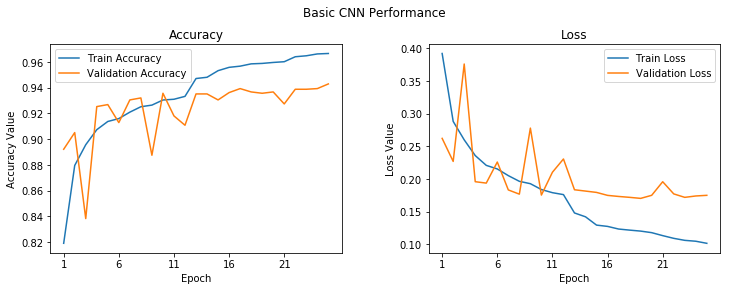

In [19]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Basic CNN Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

max_epoch = len(history.history['accuracy'])+1
epoch_list = list(range(1,max_epoch))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(1, max_epoch, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(1, max_epoch, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

## Save Model

In [20]:
model.save('vgg_frozen.h5')

# Build Image Augmentors

In [28]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
                                                                zoom_range=0.05, 
                                                                rotation_range=25,
                                                                width_shift_range=0.05, 
                                                                height_shift_range=0.05, 
                                                                shear_range=0.05, horizontal_flip=True, 
                                                                fill_mode='nearest')

val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

Labels: ['malaria', 'malaria', 'malaria', 'malaria', 'malaria']


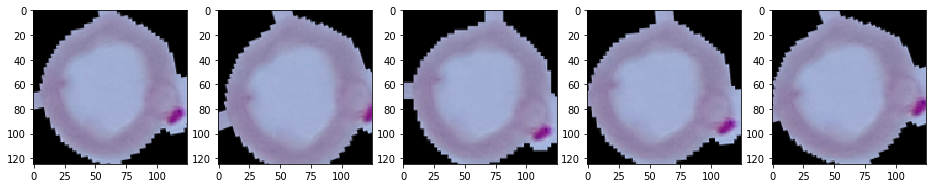

In [29]:
img_id = 0
sample_generator = train_datagen.flow(train_data[img_id:img_id+1], train_labels[img_id:img_id+1],
                                      batch_size=1)
sample = [next(sample_generator) for i in range(0,5)]
fig, ax = plt.subplots(1,5, figsize=(16, 6))
print('Labels:', [item[1][0] for item in sample])
l = [ax[i].imshow(sample[i][0][0]) for i in range(0,5)]

In [30]:
train_generator = train_datagen.flow(train_data, train_labels_enc, batch_size=BATCH_SIZE, shuffle=True)
val_generator = val_datagen.flow(val_data, val_labels_enc, batch_size=BATCH_SIZE, shuffle=False)

# Transfer Learning 
# Model 3: Fine-tuned Pre-trained CNN with Image Augmentation 

## Build Model Architecture

In [31]:
vgg = tf.keras.applications.vgg19.VGG19(include_top=False, weights='imagenet', 
                                        input_shape=INPUT_SHAPE)
# Freeze the layers
vgg.trainable = True

set_trainable = False
for layer in vgg.layers:
    if layer.name in ['block5_conv1', 'block4_conv1']:
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False
    
base_vgg = vgg
base_out = base_vgg.output
pool_out = tf.keras.layers.Flatten()(base_out)
hidden1 = tf.keras.layers.Dense(512, activation='relu')(pool_out)
drop1 = tf.keras.layers.Dropout(rate=0.3)(hidden1)
hidden2 = tf.keras.layers.Dense(512, activation='relu')(drop1)
drop2 = tf.keras.layers.Dropout(rate=0.3)(hidden2)

out = tf.keras.layers.Dense(1, activation='sigmoid')(drop2)

model = tf.keras.Model(inputs=base_vgg.input, outputs=out)
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=1e-5),
                loss='binary_crossentropy',
                metrics=['accuracy'])

print("Total Layers:", len(model.layers))
print("Total trainable layers:", sum([1 for l in model.layers if l.trainable]))

Total Layers: 28
Total trainable layers: 16


## Train Model

In [32]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=2, min_lr=0.000001)

#early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=15, 
#                                              mode='auto', baseline=None, restore_best_weights=False)
callbacks = [reduce_lr, tensorboard_callback]
train_steps_per_epoch = train_generator.n // train_generator.batch_size
val_steps_per_epoch = val_generator.n // val_generator.batch_size
history = model.fit_generator(train_generator, steps_per_epoch=train_steps_per_epoch, epochs=EPOCHS,
                              validation_data=val_generator, validation_steps=val_steps_per_epoch, 
                              verbose=1)

Epoch 1/25
271/271 [==============================] - 133s 489ms/step - loss: 0.2267 - accuracy: 0.9117 - val_loss: 0.1414 - val_accuracy: 0.9531
Epoch 2/25
271/271 [==============================] - 129s 475ms/step - loss: 0.1399 - accuracy: 0.9552 - val_loss: 0.1292 - val_accuracy: 0.9589
Epoch 3/25
271/271 [==============================] - 128s 474ms/step - loss: 0.1248 - accuracy: 0.9593 - val_loss: 0.1207 - val_accuracy: 0.9594
Epoch 4/25
271/271 [==============================] - 128s 474ms/step - loss: 0.1189 - accuracy: 0.9610 - val_loss: 0.1157 - val_accuracy: 0.9604
Epoch 5/25
271/271 [==============================] - 128s 474ms/step - loss: 0.1132 - accuracy: 0.9612 - val_loss: 0.1201 - val_accuracy: 0.9578
Epoch 6/25
271/271 [==============================] - 129s 475ms/step - loss: 0.1104 - accuracy: 0.9632 - val_loss: 0.1188 - val_accuracy: 0.9563
Epoch 7/25
271/271 [==============================] - 128s 473ms/step - loss: 0.1012 - accuracy: 0.9656 - val_loss: 0.1292 -

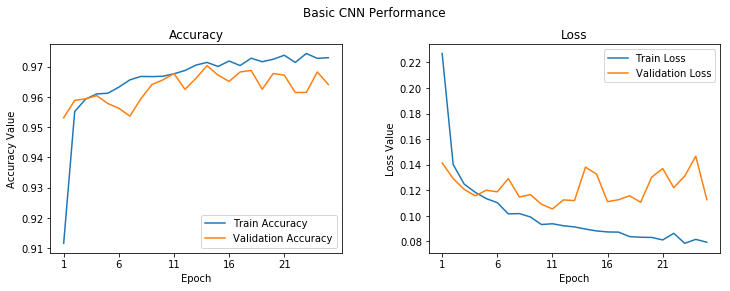

In [33]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Basic CNN Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

max_epoch = len(history.history['accuracy'])+1
epoch_list = list(range(1,max_epoch))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(1, max_epoch, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(1, max_epoch, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

## Save Model

In [34]:
model.save('vgg_finetuned.h5')

# Model Performance Evaluation

In [35]:
test_imgs_scaled = test_data / 255.
test_imgs_scaled.shape, test_labels.shape

((8268, 125, 125, 3), (8268,))

In [36]:
! ls -l --block-size=MB | grep .h5

-rw-r--r-- 1 dipanzan_sarkar dipanzan_sarkar 182MB Mar 13 18:53 basic_cnn.h5
-rw-r--r-- 1 dipanzan_sarkar dipanzan_sarkar 173MB Mar 13 20:43 vgg_finetuned.h5
-rw-r--r-- 1 dipanzan_sarkar dipanzan_sarkar 102MB Mar 13 19:29 vgg_frozen.h5


In [37]:
basic_cnn = tf.keras.models.load_model('./basic_cnn.h5')
vgg_frz = tf.keras.models.load_model('./vgg_frozen.h5')
vgg_ft = tf.keras.models.load_model('./vgg_finetuned.h5')

In [38]:
basic_cnn_preds = basic_cnn.predict(test_imgs_scaled, batch_size=512)
vgg_frz_preds = vgg_frz.predict(test_imgs_scaled, batch_size=512)
vgg_ft_preds = vgg_ft.predict(test_imgs_scaled, batch_size=512)

basic_cnn_pred_labels = le.inverse_transform([1 if pred > 0.5 else 0 
                                                  for pred in basic_cnn_preds.ravel()])
vgg_frz_pred_labels = le.inverse_transform([1 if pred > 0.5 else 0 
                                                  for pred in vgg_frz_preds.ravel()])
vgg_ft_pred_labels = le.inverse_transform([1 if pred > 0.5 else 0 
                                                  for pred in vgg_ft_preds.ravel()])

In [39]:
import model_evaluation_utils as meu
import pandas as pd

basic_cnn_metrics = meu.get_metrics(true_labels=test_labels, predicted_labels=basic_cnn_pred_labels)
vgg_frz_metrics = meu.get_metrics(true_labels=test_labels, predicted_labels=vgg_frz_pred_labels)
vgg_ft_metrics = meu.get_metrics(true_labels=test_labels, predicted_labels=vgg_ft_pred_labels)

pd.DataFrame([basic_cnn_metrics, vgg_frz_metrics, vgg_ft_metrics], 
             index=['Basic CNN', 'VGG-19 Frozen', 'VGG-19 Fine-tuned'])

,Accuracy,F1 Score:,Precision:,Recall
Basic CNN,0.9497,0.9497,0.9497,0.9497
VGG-19 Frozen,0.9376,0.9376,0.9379,0.9376
VGG-19 Fine-tuned,0.9600,0.9600,0.9610,0.9600


In [40]:
meu.display_model_performance_metrics(true_labels=test_labels, 
                                      predicted_labels=basic_cnn_pred_labels, 
                                      classes=list(set(test_labels)))

Model Performance metrics:
------------------------------

Model Classification report:
------------------------------
              precision    recall  f1-score   support

     healthy       0.95      0.95      0.95      4075
     malaria       0.95      0.95      0.95      4193

   micro avg       0.95      0.95      0.95      8268
   macro avg       0.95      0.95      0.95      8268
weighted avg       0.95      0.95      0.95      8268


Prediction Confusion Matrix:
------------------------------
                Predicted:        
                   healthy malaria
Actual: healthy       3884     191
        malaria        225    3968


In [41]:
meu.display_model_performance_metrics(true_labels=test_labels, 
                                      predicted_labels=vgg_frz_pred_labels, 
                                      classes=list(set(test_labels)))

Model Performance metrics:
------------------------------

Model Classification report:
------------------------------
              precision    recall  f1-score   support

     healthy       0.93      0.95      0.94      4075
     malaria       0.95      0.93      0.94      4193

   micro avg       0.94      0.94      0.94      8268
   macro avg       0.94      0.94      0.94      8268
weighted avg       0.94      0.94      0.94      8268


Prediction Confusion Matrix:
------------------------------
                Predicted:        
                   healthy malaria
Actual: healthy       3871     204
        malaria        312    3881


In [42]:
meu.display_model_performance_metrics(true_labels=test_labels, 
                                      predicted_labels=vgg_ft_pred_labels, 
                                      classes=list(set(test_labels)))

Model Performance metrics:
------------------------------

Model Classification report:
------------------------------
              precision    recall  f1-score   support

     healthy       0.94      0.98      0.96      4075
     malaria       0.98      0.94      0.96      4193

   micro avg       0.96      0.96      0.96      8268
   macro avg       0.96      0.96      0.96      8268
weighted avg       0.96      0.96      0.96      8268


Prediction Confusion Matrix:
------------------------------
                Predicted:        
                   healthy malaria
Actual: healthy       4004      71
        malaria        260    3933
